# How to Create an Endpoint with Vertex AI

This notebook shows how to build the model with TensorFlow and create an endpoint for a model vertex AI.

Let's import the libraries that we will use in this notebook first.

In [1]:
import os, json, math, shutil
import numpy as np
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.9.2


Let's create the enviroment variables. 

In [2]:
PROJECT=!(gcloud config get-value project)
PROJECT=PROJECT[0]

REGION = 'us-central1'
BUCKET='{}-ds'.format(PROJECT)
os.environ['ENDPOINT_NAME'] = 'flights'

os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TF_VERSION']='2-' + tf.__version__[2:3]  # needed to choose container
print("project:", PROJECT, "bucket:", BUCKET)

project: tirendaz bucket: tirendaz-ds


## Creating data sets to build the model

In this section, I'm going to create trainin and validation data. Let's get started with creating the training data first.

In [3]:
%%bigquery 
CREATE OR REPLACE TABLE tirendaz.dsongcp.flights_train_data AS
SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon
FROM tirendaz.dsongcp.flights_tzcorr f
JOIN tirendaz.dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False AND
  is_train_day = 'True'

Query complete after 0.01s: 100%|██████████| 4/4 [00:00<00:00, 2214.81query/s]                        


""


Let's take a look at the training data.

In [4]:
%%bigquery
SELECT * FROM `tirendaz.dsongcp.flights_train_data` LIMIT 5

Downloading: 100%|██████████| 5/5 [00:02<00:00,  2.38rows/s]


,ontime,dep_delay,taxi_out,distance,origin,dest,dep_hour,is_weekday,carrier,dep_airport_lat,dep_airport_lon,arr_airport_lat,arr_airport_lon
0,1.0,-22.0,5.0,548.0,OTZ,ANC,16,1,AS,66.884722,-162.598611,61.174167,-149.998056
1,1.0,-7.0,11.0,1046.0,SJU,FLL,0,1,B6,18.439444,-66.002222,26.072500,-80.152778
2,1.0,-6.0,11.0,399.0,ANC,BET,3,1,AS,61.174167,-149.998056,60.778611,-161.837222
3,1.0,-1.0,19.0,571.0,ANC,JNU,15,1,AS,61.174167,-149.998056,58.354722,-134.574722
4,1.0,-5.0,7.0,571.0,ANC,JNU,4,0,AS,61.174167,-149.998056,58.354722,-134.574722


After that let me create validation data. 

In [5]:
%%bigquery
CREATE OR REPLACE TABLE tirendaz.dsongcp.flights_eval_data AS

SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon
FROM tirendaz.dsongcp.flights_tzcorr f
JOIN tirendaz.dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False AND
  is_train_day = 'False'

Query complete after 0.00s: 100%|██████████| 4/4 [00:00<00:00, 1666.06query/s]                        


""


Now that let's take a look at the training data.

In [6]:
%%bigquery
SELECT * FROM `tirendaz.dsongcp.flights_eval_data` LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  2.61rows/s]


,ontime,dep_delay,taxi_out,distance,origin,dest,dep_hour,is_weekday,carrier,dep_airport_lat,dep_airport_lon,arr_airport_lat,arr_airport_lon
0,1.0,-2.0,11.0,831.0,RST,ATL,19,1,EV,43.908333,-92.5,33.636667,-84.427778
1,1.0,-5.0,12.0,831.0,RST,ATL,19,0,EV,43.908333,-92.5,33.636667,-84.427778
2,1.0,-10.0,9.0,831.0,RST,ATL,19,1,EV,43.908333,-92.5,33.636667,-84.427778
3,1.0,-4.0,6.0,831.0,RST,ATL,19,1,EV,43.908333,-92.5,33.636667,-84.427778
4,1.0,2.0,9.0,831.0,RST,ATL,20,0,EV,43.908333,-92.5,33.636667,-84.427778


Let's get all data that includes the training and validation data and add a column showing the train and validation data.

In [7]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_all_data AS

SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon,
  IF (is_train_day = 'True',
      IF(ABS(MOD(FARM_FINGERPRINT(CAST(f.FL_DATE AS STRING)), 100)) < 60, 'TRAIN', 'VALIDATE'),
      'TEST') AS data_split
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False

Query complete after 0.00s: 100%|██████████| 4/4 [00:00<00:00, 1396.70query/s]                        


""


Now that let's save the bucket and delete these tables using the for loop in bash.

In [8]:
%%bash
PROJECT=$(gcloud config get-value project)
for dataset in "train" "eval" "all"; do
  TABLE=dsongcp.flights_${dataset}_data
  CSV=gs://${BUCKET}/ch9/data/${dataset}.csv
  echo "Exporting ${TABLE} to ${CSV} and deleting table"
  bq --project_id=${PROJECT} extract --destination_format=CSV $TABLE $CSV
  bq --project_id=${PROJECT} rm -f $TABLE
done

Exporting dsongcp.flights_train_data to gs://tirendaz-ds/ch9/data/train.csv and deleting table
Exporting dsongcp.flights_eval_data to gs://tirendaz-ds/ch9/data/eval.csv and deleting table
Exporting dsongcp.flights_all_data to gs://tirendaz-ds/ch9/data/all.csv and deleting table


Waiting on bqjob_r5846637df461034b_00000183d2209f3e_1 ... (65s) Current status: DONE   
Waiting on bqjob_r75ce4fba1ce077f7_00000183d221b121_1 ... (23s) Current status: DONE   
Waiting on bqjob_r1dd78a45492e7439_00000183d2221c0f_1 ... (85s) Current status: DONE   


Let's take a look at these data sets.

In [9]:
!gsutil ls -lh gs://{BUCKET}/ch9/data

445.01 MiB  2022-10-13T16:17:55Z  gs://tirendaz-ds/ch9/data/all.csv
115.19 MiB  2022-10-13T16:16:28Z  gs://tirendaz-ds/ch9/data/eval.csv
296.96 MiB  2022-10-13T16:16:01Z  gs://tirendaz-ds/ch9/data/train.csv
TOTAL: 3 objects, 898801258 bytes (857.16 MiB)


## Setup in notebook

For development purposes, we'll train for just a few epochs. That's why the NUM_EXAMPLES is so low.

In [10]:
DEVELOP_MODE = True
NUM_EXAMPLES = 5000*1000 # doesn't need to be precise but get order of magnitude right.

In [11]:
# use wildcard in the name so that it works even if you have multiple files
training_data_uri = 'gs://{}/ch9/data/train*'.format(BUCKET)
validation_data_uri = 'gs://{}/ch9/data/eval*'.format(BUCKET)

Let's set model parameters.

In [12]:
NBUCKETS = 5 #
NEMBEDS = 3
TRAIN_BATCH_SIZE = 64
DNN_HIDDEN_UNITS = '64,32'

Let's create the input data pipeline

In [13]:
if DEVELOP_MODE:
    train_df = tf.data.experimental.make_csv_dataset(training_data_uri, batch_size=5)
    for n, data in enumerate(train_df):
        numpy_data = {k: v.numpy() for k, v in data.items()} # .numpy() works only in eager mode
        print(n, numpy_data)
        if n==1: break

2022-10-13 16:18:07.336684: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-10-13 16:18:07.336802: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-13 16:18:07.336850: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow-2-9-20221013-141934): /proc/driver/nvidia/version does not exist
2022-10-13 16:18:07.385301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler fla

0 {'ontime': array([1, 1, 1, 1, 0], dtype=int32), 'dep_delay': array([ -3, -19,  -4, -10,  96], dtype=int32), 'taxi_out': array([15,  8, 12, 17,  9], dtype=int32), 'distance': array([362, 204, 562, 204, 571], dtype=int32), 'origin': array([b'OAK', b'SCC', b'XNA', b'BRW', b'JNU'], dtype=object), 'dest': array([b'ONT', b'BRW', b'CVG', b'SCC', b'ANC'], dtype=object), 'dep_hour': array([18,  1, 22,  4, 23], dtype=int32), 'is_weekday': array([1, 1, 1, 0, 0], dtype=int32), 'carrier': array([b'WN', b'AS', b'OO', b'AS', b'AS'], dtype=object), 'dep_airport_lat': array([37.72278 , 70.19556 , 36.281666, 71.28472 , 58.35472 ],
      dtype=float32), 'dep_airport_lon': array([-122.22139, -148.46584,  -94.30778, -156.76862, -134.57472],
      dtype=float32), 'arr_airport_lat': array([34.05611 , 71.28472 , 39.04889 , 70.19556 , 61.174168],
      dtype=float32), 'arr_airport_lon': array([-117.60111, -156.76862,  -84.66778, -148.46584, -149.99806],
      dtype=float32)}
1 {'ontime': array([1, 1, 0, 1, 0

2022-10-13 16:19:58.723919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 10000
2022-10-13 16:19:58.860383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


The dataset consists of the label and features. It is good idea to seperate these columns. Let's create the features and label variables.

In [14]:
def features_and_labels(features):
  label = features.pop('ontime') # this is what we will train for
  return features, label

Let’s creaet a read_dataset() function that reads the training data, yielding batch_size examples each time.

In [15]:
def read_dataset(pattern, batch_size, mode=tf.estimator.ModeKeys.TRAIN, truncate=None):
    dataset = tf.data.experimental.make_csv_dataset(pattern, batch_size, num_epochs=1)
    dataset = dataset.map(features_and_labels)
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(batch_size*10)
        dataset = dataset.repeat()
        dataset = dataset.prefetch(1)
    if truncate is not None:
        dataset = dataset.take(truncate)
    return dataset

if DEVELOP_MODE:
    print("Checking input pipeline")
    one_item = read_dataset(training_data_uri, batch_size=2, truncate=1)
    print(list(one_item)) # should print one batch of 2 items

Checking input pipeline
[(OrderedDict([('dep_delay', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([60, -7], dtype=int32)>), ('taxi_out', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 6, 10], dtype=int32)>), ('distance', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([511, 466], dtype=int32)>), ('origin', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'BOI', b'ACY'], dtype=object)>), ('dest', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'OAK', b'MYR'], dtype=object)>), ('dep_hour', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 3, 11], dtype=int32)>), ('is_weekday', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([0, 1], dtype=int32)>), ('carrier', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'WN', b'NK'], dtype=object)>), ('dep_airport_lat', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([43.564445, 39.4575  ], dtype=float32)>), ('dep_airport_lon', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-116.22278 ,  -74.577225], dtype=float32)>), ('a

2022-10-13 16:21:24.492651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 10000
2022-10-13 16:21:24.492712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 10000
2022-10-13 16:21:24.653795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-10-13 16:21:24.654197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 20
2022-10-13 16:21:24.654225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 20
2022-10-13 16:21:24.655869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


## Create TensorFlow wide-and-deep model

Let's create feature columns, and do some discretization and feature engineering.

In [16]:
import tensorflow as tf

real = {
    colname : tf.feature_column.numeric_column(colname) 
          for colname in 
            (
                'dep_delay,taxi_out,distance,dep_hour,is_weekday,' +
                'dep_airport_lat,dep_airport_lon,' +
                'arr_airport_lat,arr_airport_lon'
            ).split(',')
    }
sparse = {
      'carrier': tf.feature_column.categorical_column_with_vocabulary_list('carrier',
                  vocabulary_list='AS,VX,F9,UA,US,WN,HA,EV,MQ,DL,OO,B6,NK,AA'.split(',')),
      'origin' : tf.feature_column.categorical_column_with_hash_bucket('origin', hash_bucket_size=1000),
      'dest'   : tf.feature_column.categorical_column_with_hash_bucket('dest', hash_bucket_size=1000),
    }

inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32') for colname in real.keys()
    }

inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string') 
          for colname in sparse.keys()
    })

## Feature engineering

In [17]:
latbuckets = np.linspace(20.0, 50.0, NBUCKETS).tolist()  # USA
lonbuckets = np.linspace(-120.0, -70.0, NBUCKETS).tolist() # USA
disc = {}
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], latbuckets) 
          for key in ['dep_airport_lat', 'arr_airport_lat']
    })
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], lonbuckets) 
          for key in ['dep_airport_lon', 'arr_airport_lon']
    })

# cross columns that make sense in combination
sparse['dep_loc'] = tf.feature_column.crossed_column(
    [disc['d_dep_airport_lat'], disc['d_dep_airport_lon']], NBUCKETS*NBUCKETS)
sparse['arr_loc'] = tf.feature_column.crossed_column(
    [disc['d_arr_airport_lat'], disc['d_arr_airport_lon']], NBUCKETS*NBUCKETS)
sparse['dep_arr'] = tf.feature_column.crossed_column([sparse['dep_loc'], sparse['arr_loc']], NBUCKETS ** 4)

# embed all the sparse columns
embed = {
       'embed_{}'.format(colname) : tf.feature_column.embedding_column(col, NEMBEDS)
          for colname, col in sparse.items()
    }
real.update(embed)

# one-hot encode the sparse columns
sparse = {
    colname : tf.feature_column.indicator_column(col)
          for colname, col in sparse.items()
    }

if DEVELOP_MODE:
    print(sparse.keys())
    print(real.keys())

dict_keys(['carrier', 'origin', 'dest', 'dep_loc', 'arr_loc', 'dep_arr'])
dict_keys(['dep_delay', 'taxi_out', 'distance', 'dep_hour', 'is_weekday', 'dep_airport_lat', 'dep_airport_lon', 'arr_airport_lat', 'arr_airport_lon', 'embed_carrier', 'embed_origin', 'embed_dest', 'embed_dep_loc', 'embed_arr_loc', 'embed_dep_arr'])


## Train the model and evaluate once in a while

In [18]:
output_dir='gs://{}/ch9/trained_model'.format(BUCKET)
os.environ['OUTDIR'] = output_dir  # needed for deployment
print('Writing trained model to {}'.format(output_dir))

Writing trained model to gs://tirendaz-ds/ch9/trained_model


In [19]:
!gsutil -m rm -rf $OUTDIR

Removing gs://tirendaz-ds/ch9/trained_model/export/#1665676258844548...
Removing gs://tirendaz-ds/ch9/trained_model/export/flights_20221013-155050/#1665676259071286...
Removing gs://tirendaz-ds/ch9/trained_model/#1665676208909515...
Removing gs://tirendaz-ds/ch9/trained_model/checkpoints/#1665676209136572...
Removing gs://tirendaz-ds/ch9/trained_model/checkpoints/checkpoint#1665676249448818...
Removing gs://tirendaz-ds/ch9/trained_model/checkpoints/flights.cpt.data-00000-of-00001#1665676248300996...
Removing gs://tirendaz-ds/ch9/trained_model/export/flights_20221013-155050/assets/#1665676262864640...
Removing gs://tirendaz-ds/ch9/trained_model/checkpoints/flights.cpt.index#1665676248582548...
Removing gs://tirendaz-ds/ch9/trained_model/export/flights_20221013-155050/saved_model.pb#1665676263880550...
Removing gs://tirendaz-ds/ch9/trained_model/export/flights_20221013-155050/variables/variables.data-00000-of-00001#1665676261711507...
Removing gs://tirendaz-ds/ch9/trained_model/export/fl

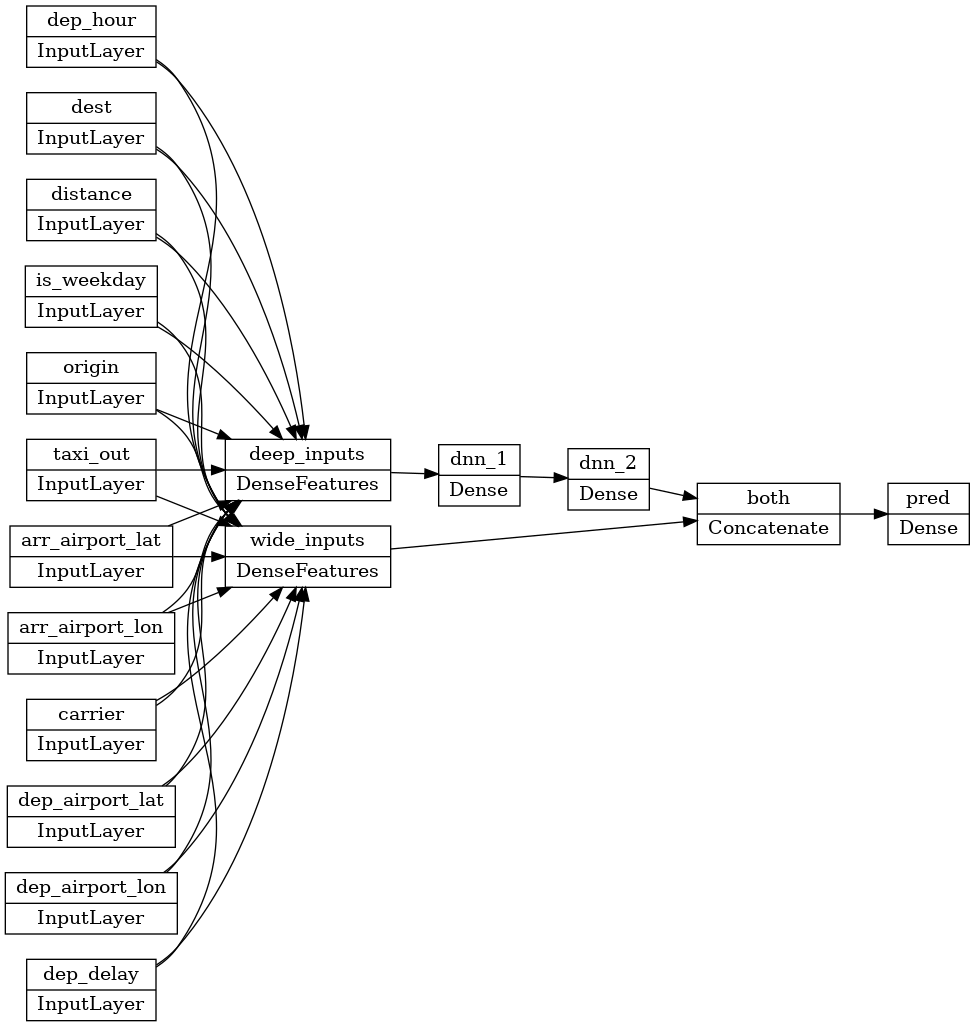

In [20]:
# Build a wide-and-deep model.
def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(dnn_feature_columns, name='deep_inputs')(inputs)
    layers = [int(x) for x in dnn_hidden_units.split(',')]
    for layerno, numnodes in enumerate(layers):
        deep = tf.keras.layers.Dense(numnodes, activation='relu', name='dnn_{}'.format(layerno+1))(deep)        
    wide = tf.keras.layers.DenseFeatures(linear_feature_columns, name='wide_inputs')(inputs)
    both = tf.keras.layers.concatenate([deep, wide], name='both')
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    
model = wide_and_deep_classifier(
    inputs,
    linear_feature_columns = sparse.values(),
    dnn_feature_columns = real.values(),
    dnn_hidden_units = DNN_HIDDEN_UNITS)
tf.keras.utils.plot_model(model, 'flights_model.png', show_shapes=False, rankdir='LR')

In [21]:
# training and evaluation dataset
train_batch_size = TRAIN_BATCH_SIZE
if DEVELOP_MODE:
    eval_batch_size = 100
    steps_per_epoch = 3
    epochs = 2
    num_eval_examples = eval_batch_size*10
else:
    eval_batch_size = 100
    steps_per_epoch = NUM_EXAMPLES // train_batch_size
    epochs = 10
    num_eval_examples = eval_batch_size * 100

train_dataset = read_dataset(training_data_uri, train_batch_size)
eval_dataset = read_dataset(validation_data_uri, eval_batch_size, tf.estimator.ModeKeys.EVAL, num_eval_examples)

checkpoint_path = '{}/checkpoints/flights.cpt'.format(output_dir)
shutil.rmtree(checkpoint_path, ignore_errors=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_dataset, 
                    validation_data=eval_dataset,
                    epochs=epochs, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[cp_callback])

Epoch 1/2


2022-10-13 16:23:48.457930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 10000
2022-10-13 16:23:48.457994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 10000
2022-10-13 16:23:48.620730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-10-13 16:23:48.622336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 640
2022-10-13 16:23:48.623629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 640
2022-10-13 16:23:48.918137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 284 of 640
2022-10-13 16:23:49.333476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1/3 [=========>....................] - ETA: 1:09 - loss: 0.4822 - accuracy: 0.8125

2022-10-13 16:24:21.050562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 10000
2022-10-13 16:24:21.050636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 10000
2022-10-13 16:24:21.160197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 1: saving model to gs://tirendaz-ds/ch9/trained_model/checkpoints/flights.cpt
3/3 [==============================] - 75s 20s/step - loss: 0.4045 - accuracy: 0.8698 - val_loss: 0.4038 - val_accuracy: 0.8372
Epoch 2/2
1/3 [=========>....................] - ETA: 0s - loss: 0.3511 - accuracy: 0.8750

2022-10-13 16:24:48.321976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 10000
2022-10-13 16:24:48.443883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 2: saving model to gs://tirendaz-ds/ch9/trained_model/checkpoints/flights.cpt
3/3 [==============================] - 25s 13s/step - loss: 0.3394 - accuracy: 0.8802 - val_loss: 0.3476 - val_accuracy: 0.8543


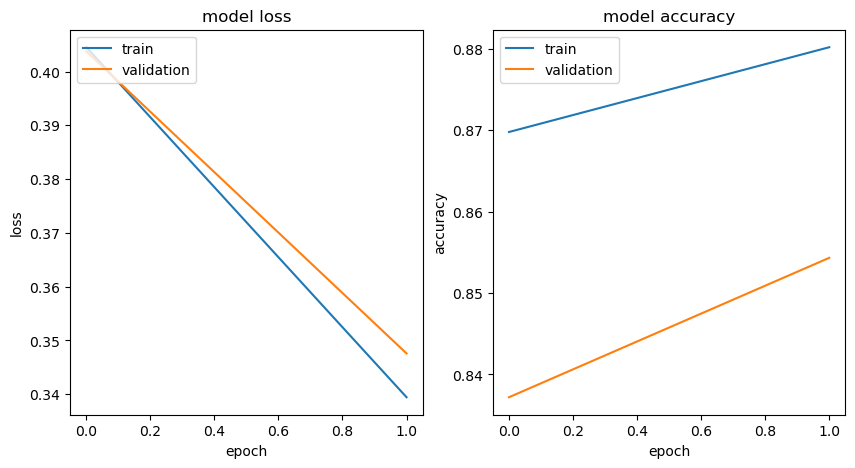

In [22]:
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'accuracy']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Export the trained model

In [23]:
import time
export_dir = '{}/export/flights_{}'.format(output_dir, time.strftime("%Y%m%d-%H%M%S"))
print('Exporting to {}'.format(export_dir))
tf.saved_model.save(model, export_dir)

Exporting to gs://tirendaz-ds/ch9/trained_model/export/flights_20221013-162541
INFO:tensorflow:Assets written to: gs://tirendaz-ds/ch9/trained_model/export/flights_20221013-162541/assets


## Deploy model to Vertex AI

In [24]:
%%bash
# note TF_VERSION and ENDPOINT_NAME set in 1st cell
# TF_VERSION=2-6
# ENDPOINT_NAME=flights

TIMESTAMP=$(date +%Y%m%d-%H%M%S)
MODEL_NAME=${ENDPOINT_NAME}-${TIMESTAMP}
EXPORT_PATH=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $EXPORT_PATH

if [[ $(gcloud ai endpoints list --region=$REGION \
        --format='value(DISPLAY_NAME)' --filter=display_name=${ENDPOINT_NAME}) ]]; then
    echo "Endpoint for $MODEL_NAME already exists"
else
    # create model
    echo "Creating Endpoint for $MODEL_NAME"
    gcloud ai endpoints create --region=${REGION} --display-name=${ENDPOINT_NAME}
fi

ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo "ENDPOINT_ID=$ENDPOINT_ID"

# delete any existing models with this name
for MODEL_ID in $(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME}); do
    echo "Deleting existing $MODEL_NAME ... $MODEL_ID "
    gcloud ai models delete --region=$REGION $MODEL_ID
done

# upload model
gcloud beta ai models upload --region=$REGION --display-name=$MODEL_NAME \
     --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.${TF_VERSION}:latest \
     --artifact-uri=$EXPORT_PATH
MODEL_ID=$(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME})
echo "MODEL_ID=$MODEL_ID"

# deploy model to endpoint
gcloud ai endpoints deploy-model $ENDPOINT_ID \
  --region=$REGION \
  --model=$MODEL_ID \
  --display-name=$MODEL_NAME \
  --machine-type=n1-standard-2 \
  --min-replica-count=1 \
  --max-replica-count=1 \
  --traffic-split=0=100

gs://tirendaz-ds/ch9/trained_model/export/flights_20221013-162541/
Creating Endpoint for flights-20221013-162555
ENDPOINT_ID=1662536347988000768
MODEL_ID=659174813037756416


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [8467715422077059072]...
..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................done.
Created Vertex AI endpoint: projects/909214775797/locations/us-ce

In [25]:
%%writefile example_input.json
{"instances": [
  {"dep_hour": 2, "is_weekday": 1, "dep_delay": 40, "taxi_out": 17, "distance": 41, "carrier": "AS", "dep_airport_lat": 58.42527778, "dep_airport_lon": -135.7075, "arr_airport_lat": 58.35472222, "arr_airport_lon": -134.57472222, "origin": "GST", "dest": "JNU"},
  {"dep_hour": 22, "is_weekday": 0, "dep_delay": -7, "taxi_out": 7, "distance": 201, "carrier": "HA", "dep_airport_lat": 21.97611111, "dep_airport_lon": -159.33888889, "arr_airport_lat": 20.89861111, "arr_airport_lon": -156.43055556, "origin": "LIH", "dest": "OGG"}
]}

Writing example_input.json


In [26]:
%%bash
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo $ENDPOINT_ID
gcloud ai endpoints predict $ENDPOINT_ID --region=$REGION --json-request=example_input.json

1662536347988000768
[[0.530583501], [0.943778515]]


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]


In [27]:
%%bash
PROJECT=$(gcloud config get-value project)
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})

curl -X POST \
  -H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
  -H "Content-Type: application/json; charset=utf-8" \
  -d @example_input.json \
  "https://${REGION}-aiplatform.googleapis.com/v1/projects/${PROJECT}/locations/${REGION}/endpoints/${ENDPOINT_ID}:predict"

{
  "predictions": [
    [
      0.530583501
    ],
    [
      0.943778515
    ]
  ],
  "deployedModelId": "4848463648445693952",
  "model": "projects/909214775797/locations/us-central1/models/659174813037756416",
  "modelDisplayName": "flights-20221013-162555",
  "modelVersionId": "1"
}


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   833    0   290  100   543   1150   2154 --:--:-- --:--:-- --:--:--  3305


In [28]:
%%writefile example_input_tirendaz.json
{"instances": [
  {"dep_hour": 3, "is_weekday": 2, "dep_delay": 38, "taxi_out": 26, "distance": 42, "carrier": "AS", "dep_airport_lat": 58.42527778, "dep_airport_lon": -135.7075, "arr_airport_lat": 58.35472222, "arr_airport_lon": -134.57472222, "origin": "GST", "dest": "JNU"},
  {"dep_hour": 25, "is_weekday": 0, "dep_delay": -7, "taxi_out": 9, "distance": 301, "carrier": "HA", "dep_airport_lat": 21.97611111, "dep_airport_lon": -159.33888889, "arr_airport_lat": 20.89861111, "arr_airport_lon": -156.43055556, "origin": "LIH", "dest": "OGG"}
]}

Writing example_input_tirendaz.json


In [29]:
%%bash
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo $ENDPOINT_ID
gcloud ai endpoints predict $ENDPOINT_ID --region=$REGION --json-request=example_input_tirendaz.json

1662536347988000768
[[0.558415711], [0.959950209]]


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]


In [31]:
%%bash
PROJECT=$(gcloud config get-value project)
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})

curl -X POST \
  -H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
  -H "Content-Type: application/json; charset=utf-8" \
  -d @example_input_tirendaz.json \
  "https://${REGION}-aiplatform.googleapis.com/v1/projects/${PROJECT}/locations/${REGION}/endpoints/${ENDPOINT_ID}:predict"

{
  "predictions": [
    [
      0.558415711
    ],
    [
      0.959950209
    ]
  ],
  "deployedModelId": "4848463648445693952",
  "model": "projects/909214775797/locations/us-central1/models/659174813037756416",
  "modelDisplayName": "flights-20221013-162555",
  "modelVersionId": "1"
}


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   833    0   290  100   543   1150   2154 --:--:-- --:--:-- --:--:--  3305


## Resources

- Data Science on the Google Cloud Platform, 2nd Edition

Follow me [Twitter](https://twitter.com/TirendazAcademy) | [Instagram](https://www.instagram.com/tirendazacademy) | [Medium](https://tirendazacademy.medium.com) | [YouTube](https://www.youtube.com/channel/UCFU9Go20p01kC64w-tmFORw) | [Tiktok](https://www.tiktok.com/@tirendazacademy) 😊